<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#T-distribution" data-toc-modified-id="T-distribution-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>T-distribution</a></span><ul class="toc-item"><li><span><a href="#Q-Q-Plots" data-toc-modified-id="Q-Q-Plots-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Q-Q Plots</a></span></li></ul></li><li><span><a href="#VaR-by-EWMA" data-toc-modified-id="VaR-by-EWMA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>VaR by EWMA</a></span><ul class="toc-item"><li><span><a href="#Volatility" data-toc-modified-id="Volatility-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Volatility</a></span></li><li><span><a href="#Quantile" data-toc-modified-id="Quantile-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Quantile</a></span></li></ul></li><li><span><a href="#Volatility-by-GARCH" data-toc-modified-id="Volatility-by-GARCH-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Volatility by GARCH</a></span></li><li><span><a href="#Comparision" data-toc-modified-id="Comparision-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Comparision</a></span></li></ul></div>

## Introduction

Margin in the context “buying on margin”, refers to the initial payment that investors madeto the broker for the asset. For example, 10% down and 90% financed means investor pay10% of the asset’s price, which is the margin, and borrow the rest 90% from a bank or abroker. This is equivalent to use a leverage, allowing magnification of potential profits, but also, potential losses. Therefore, the margin rate requires to be carefully pondered.

Regulator hope that at every deal, there is sufficient margin to cover potential losses, while not harming capital liquidity. Smaller margin portion for investors means more diversified choice given the fact that the total capital of them are limited. 

This notebook tris to replicate the <b>Single margin parameter</b> mentioned in the following document: https://www.ecc.de/fileadmin/ECC/Downloads/Risk_Management/Margining/margining-data.pdf

This margin parameter, can be decomposed to two parts: an estimation of quantile of the residual $R_X$ and the volatility of underlying's price $\sigma_X$.  

This method is compared to the estimation of GARCH(1,1) model. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import scipy.stats as stats
from scipy.stats import t

import statsmodels.api as sm
import statistics

from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import norm

In [2]:
pd.options.display.max_rows = 300

## T-distribution

Financial data is known for its heavy tail feature. 

This section just want to check that the heavy tail effect do appear in market data, and can be sort of compesented by using <b>student-T</b> distribution(parameter to be determined by <b>moments method</b>) instead ofg aussian distribution. 

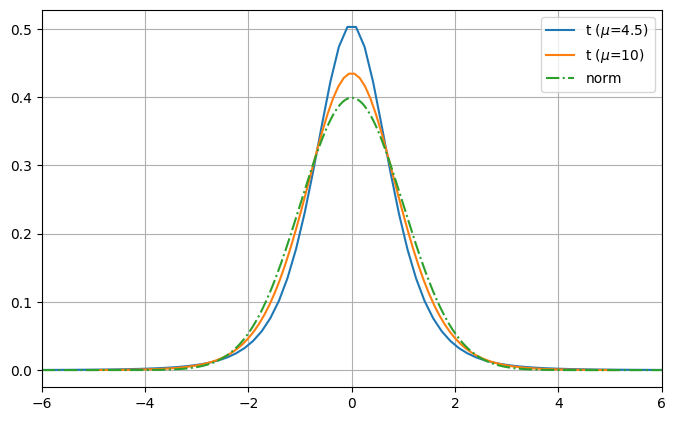

In [3]:
plt.figure(figsize = (8,5), dpi = 100)
#--------- t ----------
for mu in [4.5,10]:
    rv = t(mu, loc = 0, scale = np.sqrt((mu-2)/mu))
    x = np.linspace(rv.ppf(0.0001), rv.ppf(0.9999), 100)
    y = rv.pdf(x)
    plt.xlim(-6,6)
    plt.plot(x,y, label = rf"t ($\mu$={mu})")

#--------- normal -----
x_axis = np.arange(-6,6, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1), "-.", label = "norm")

plt.legend(); plt.grid()
plt.show()

In [4]:
from arch import arch_model
import arch.data.sp500  # data source
import datetime as dt
import sys

In [5]:
data = arch.data.sp500.load()
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-04,1229.229980,1248.810059,1219.099976,1228.099976,1228.099976,877000000
1999-01-05,1228.099976,1246.109985,1228.099976,1244.780029,1244.780029,775000000
1999-01-06,1244.780029,1272.500000,1244.780029,1272.339966,1272.339966,986900000
1999-01-07,1272.339966,1272.339966,1257.680054,1269.729980,1269.729980,863000000
1999-01-08,1269.729980,1278.239990,1261.819946,1275.089966,1275.089966,937800000


In [6]:
len(data.dropna()) == len(data)

True

In [7]:
rt = 100*data[['Adj Close']].pct_change().dropna()

remember that here we multiplied daily return by 100.

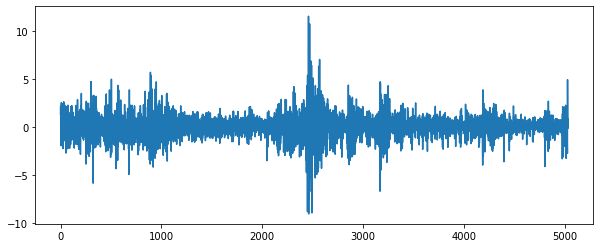

In [8]:
plt.figure(figsize = (10,4))
plt.plot(np.arange(len(rt)), rt)
plt.show()

By momentum method:
Suppose $X\sim \lambda t(\nu)$
* $$\lambda = (\frac{\mu_2(\nu-2)}{\nu})^{1/2}$$
* $$\nu = \frac{4\mu_4-6\mu_2^2}{\mu_4-2\mu_2^2}$$

en q
* mu2: avg {x xexp 2} each rts;
* mu4: avg {x xexp 4} each rts;
* nu:  1+(6* mu2* mu2%(mu4-3 * mu2* mu2))
* lambda: sqrt(mu2* (nu-2)%nu )

In [9]:
mu2 = (rt.values**2).mean()
mu4 = (rt.values**4).mean()
mu2, mu4

(1.4475583691870835, 23.7398514923449)

In [10]:
nu = (4*mu4-6*mu2*mu2)/(mu4-2*mu2*mu2)
lambd = np.sqrt(mu2*(nu-2)/nu)
nu, lambd

(4.21437670694364, 0.8721217509837789)

In [11]:
sigma_n = np.sqrt(rt.values.var())

In [12]:
import matplotlib.patches as patches

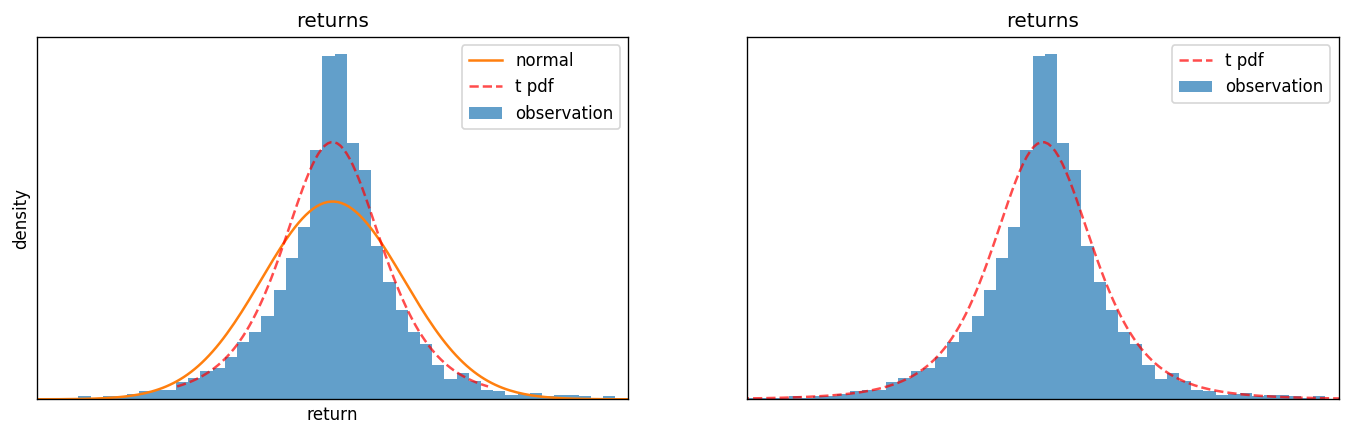

In [13]:
nr = 1; nc = 2
fig, axs = plt.subplots(nrows = nr, ncols = nc, figsize = (14,4), dpi = 120, subplot_kw={'xticks':[], 'yticks':[]})


ax = axs.flat[0]
ax.hist(rt.values.reshape(1,-1)[0], bins = 100, density = True, label = 'observation', alpha = 0.7)
mu = 0; ns = 5
x1 = np.linspace(mu-ns*sigma_n, mu+ns*sigma_n, 200)
x2 = np.linspace(mu-ns*(nu-2)/nu, mu+ns*(nu-2)/nu, 100)
ax.set_title('returns')
ax.plot(x1, stats.norm.pdf(x1, 0, sigma_n), label = 'normal')
ax.plot(x2, t.pdf(x2, df=nu, loc = 0, scale = lambd), 'r--', label = 't pdf', alpha = 0.7)
ax.set_xlabel("return")
ax.set_ylabel("density")
ax.set_xlim(-5,5)
ax.legend()
ax.grid()

ax = axs.flat[1]
ax.hist(rt.values.reshape(1,-1)[0], bins = 100, density = True, label = 'observation', alpha = 0.7)
mu = 0; ns = 5
x1 = np.linspace(mu-ns*sigma_n, mu+ns*sigma_n, 200)
# x2 = np.linspace(mu-ns*(nu-2)/nu, mu+ns*(nu-2)/nu, 100)
ax.set_title('returns')
# ax.plot(x1, stats.norm.pdf(x1, 0, sigma_n), label = 'normal')
ax.plot(x1, t.pdf(x1, df=nu, loc = 0, scale = lambd), 'r--', label = 't pdf', alpha = 0.7)
ax.set_xlim(-5,5)
ax.legend()
ax.grid()


plt.show()

* Should try generalized error distribution

### Q-Q Plots

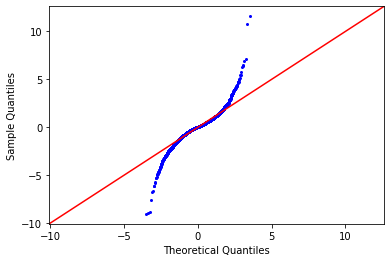

In [14]:
sm.qqplot(rt.values.reshape(1,-1)[0], line = '45', marker = '.', markersize = 4)
plt.show()

In [15]:
# ### Test for white noise
# Ljung-box test

In [16]:
returns = rt.values.reshape(1,-1)[0]
returns

array([ 1.35819993,  2.21404074, -0.20513275, ...,  0.85626808,
       -0.12415826,  0.84924844])

In [17]:
# # ARCH(1,1)
# tmp = sm.tsa.ARMA(returns, (1,1)).fit(disp=-1)
# sm.stats.acorr_ljungbox(tmp.resid, lags=[5,10,20])

## VaR by EWMA

### Volatility

In [18]:
# alpha = 0.99 
# EWMA = pd.DataFrame.ewm(rt, min_periods=255, com = 1/alpha - 1 )
# rt.ewm(min_periods = 255, com = 1/alpha -1)

In [19]:
rt = rt.rename(columns = {'Adj Close':'rt'})

In [20]:
n_back = 255
returns = np.array(rt.rt)
lambd = 0.99
denominator = sum([lambd**i for i in range(1,n_back+1)])

In [21]:
lenn = len(returns)
ewma = [0]*255
for i in range(255, lenn):
    tmp = 0
    for j in range(i-255,i): # 255 days before
        tmp += ((lambd**(i-j))*(returns[j]**2))
    ewma.append(tmp/denominator)


In [22]:
len(ewma)

5030

In [23]:
ewma = np.sqrt(np.array(ewma))
rt['ewma'] = ewma

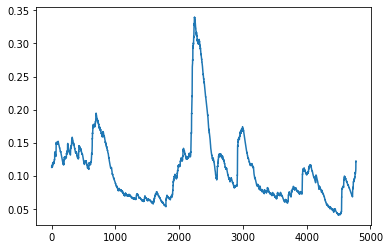

In [24]:
plt.plot(np.arange(len(ewma[255:])), ewma[255:]/10)

### Quantile

In [25]:
sum(returns/100 > 1)

0

In [26]:
# left_q = [0]*255*2
# right_q = [0]*255*2
residuals = [0]*255*2
residuals_origin = [0]*255*2
for i in range(255*2, lenn):
    r = returns[i-255:i]
    sigma = ewma[i-255-1:i-1] # 这里和ewma[i-255:i]差别很大
    tmp = r/sigma
    left_q = abs(np.quantile(tmp, 0.01))
    right_q = abs(np.quantile(tmp, 0.99))
    res = 0.5*(left_q+right_q)
    residuals_origin.append(res)
    if res > 3.5: res = 3.5 #  according to information at ECC website, residual is truncated
    if res < 2.66: res = 2.66
    residuals.append(res)
rt['residuals'] = residuals

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


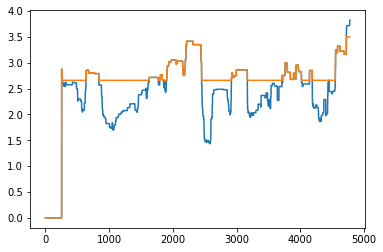

In [27]:
plt.plot(np.arange(len(residuals_origin[255:])), residuals_origin[255:], label = 'no-truncated')
plt.plot(np.arange(len(residuals[255:])), residuals[255:])
plt.show()

In [28]:
rt['EWMA'] = np.array(residuals)*np.sqrt(ewma)/100

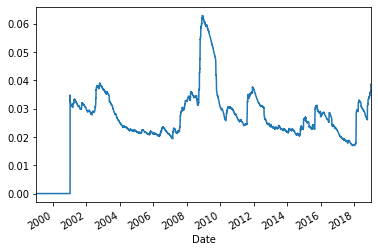

In [29]:
rt.EWMA.plot()
plt.show()

In this section we just implemented ECC single margin parameter. For the part of "quantile", I used a simple empirical quantile. More sophisticated ways includes calibrating $\frac{X_t}{\sigma_X(t-1)}$ by gaussian or student-T distribution, then estimate the quantile. This can be referred in previous section, I won't implement here.

The result can be obtained by:
```
np.array(residuals)*np.sqrt(ewma)/100
```
That I will later compare it with GARCH  result.

## Volatility by GARCH

GARCH model also gives an estimation of volatility. We constate that fitting by student-T or gaussian won't change much the result in this case that I use daily data and do forecasting for only 1 day.

Usually a GARCH(1,1)  model already works, and we could see the residual plot to see whether there is information left. 

In [30]:
import datetime as dt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import scipy.stats as stats
import pylab
import statistics


In [31]:
rt = rt.rename(columns = {'Adj Close':'rt'})

In [32]:
ES = data[['Adj Close']][-2000:]
ES= pd.concat([ES, rt], axis = 1).dropna()
ES.head()

,Adj Close,rt,ewma,residuals,EWMA
Date,,,,,
2011-01-20,1280.260010,-0.129496,0.975683,2.66,0.026275
2011-01-21,1283.349976,0.241355,0.970382,2.66,0.026203
2011-01-24,1290.839966,0.583628,0.965168,2.66,0.026133
2011-01-25,1291.180054,0.026346,0.961763,2.66,0.026086
2011-01-26,1296.630005,0.422091,0.955378,2.66,0.026000


In [33]:
last_obs = '2016-01-04'

In [34]:
from arch.univariate import ConstantMean, GARCH, StudentsT

In [35]:
md1 = ConstantMean(ES.rt)
md1.volatility = GARCH(p=1, o=0, q = 1)
res1 = md1.fit(update_freq=0, disp = 'off', first_obs=0, last_obs = last_obs)
print(res1.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                     rt   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -1561.35
Distribution:                  Normal   AIC:                           3130.71
Method:            Maximum Likelihood   BIC:                           3151.22
                                        No. Observations:                 1246
Date:                Tue, Nov 03 2020   Df Residuals:                     1242
Time:                        21:42:33   Df Model:                            4
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0661  2.126e-02      3.109  1.874e-03 [2.444e-0

In [36]:
import seaborn
seaborn.set_style('darkgrid')
plt.rc("figure", figsize=(16,6))
plt.rc("savefig", dpi = 90)
plt.rc("font", family = "sans-serif")
plt.rc("font", size = 14)

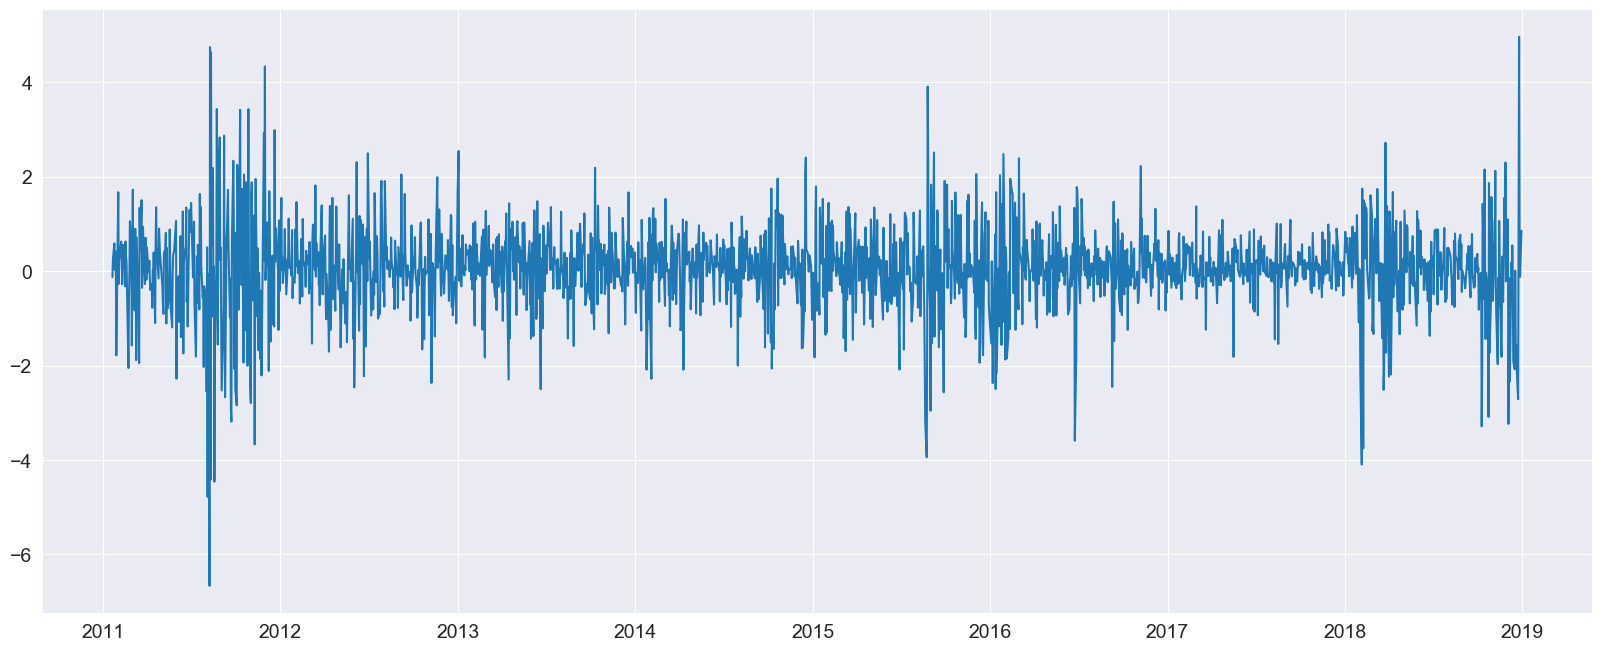

In [37]:
plt.figure(figsize = (20,8), dpi = 100)
plt.plot(ES.rt)
plt.show()

In [38]:
md2 = ConstantMean(ES.rt)
md2.volatility = GARCH(p=1, o=0, q = 1)
md2.distribution = StudentsT()
res2 = md2.fit(update_freq=0, disp = 'off', first_obs=0, last_obs = last_obs)
print(res2.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                           rt   R-squared:                      -0.002
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                            GARCH   Log-Likelihood:               -1545.01
Distribution:      Standardized Student's t   AIC:                           3100.02
Method:                  Maximum Likelihood   BIC:                           3125.66
                                              No. Observations:                 1246
Date:                      Tue, Nov 03 2020   Df Residuals:                     1241
Time:                              21:42:34   Df Model:                            5
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

<Figure size 2000x1000 with 0 Axes>

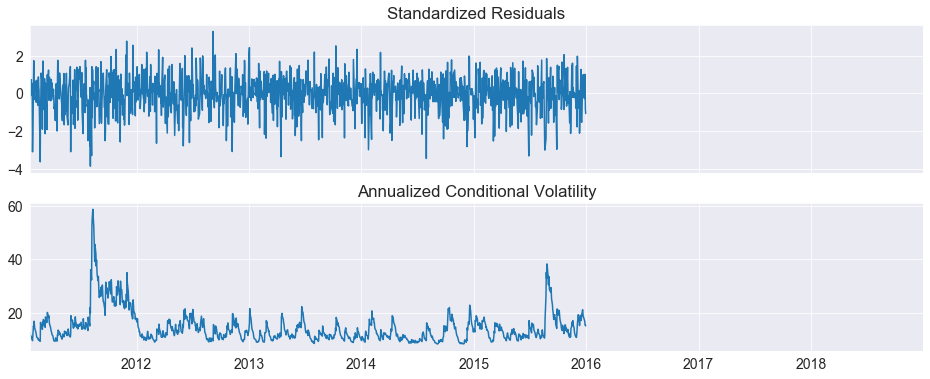

In [39]:
plt.figure(figsize=(20,10), dpi = 100)
res2.plot(annualize = 'D')
plt.show()

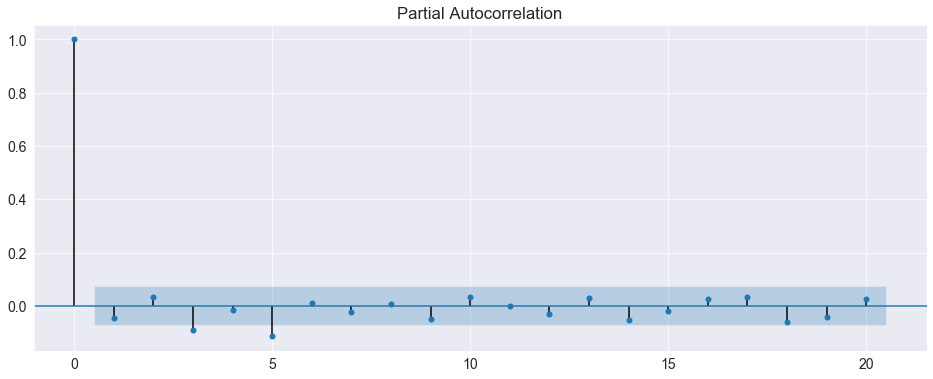

In [40]:
mylag = 20
plot_pacf(res2.resid.dropna(), alpha = 0.01, lags = mylag)
plt.show()

Still have one point at t=5 get out of the confiance region, but generally it's acceptable.

## Comparision 

In this section we visualize volatility estimated by EWMA and GARCH(1,1). 

In [41]:
ES = data[['Adj Close']][-2000:]
ES= pd.concat([ES, rt], axis = 1).dropna()
ES.tail()

,Adj Close,rt,ewma,residuals,EWMA
Date,,,,,
2018-12-24,2351.100098,-2.711225,1.084606,3.5,0.036451
2018-12-26,2467.699951,4.959374,1.115353,3.5,0.036964
2018-12-27,2488.830078,0.856268,1.223921,3.5,0.038721
2018-12-28,2485.739990,-0.124158,1.221041,3.5,0.038675
2018-12-31,2506.850098,0.849248,1.214976,3.5,0.038579


In [42]:
ES.reset_index(inplace=True)

In [43]:
ES.Date = ES.Date.apply(lambda x: x.to_pydatetime())

In [44]:
ES.Date.values

array(['2011-01-20T00:00:00.000000000', '2011-01-21T00:00:00.000000000',
       '2011-01-24T00:00:00.000000000', ...,
       '2018-12-27T00:00:00.000000000', '2018-12-28T00:00:00.000000000',
       '2018-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [45]:
ES.head()

,Date,Adj Close,rt,ewma,residuals,EWMA
0,2011-01-20,1280.260010,-0.129496,0.975683,2.66,0.026275
1,2011-01-21,1283.349976,0.241355,0.970382,2.66,0.026203
2,2011-01-24,1290.839966,0.583628,0.965168,2.66,0.026133
3,2011-01-25,1291.180054,0.026346,0.961763,2.66,0.026086
4,2011-01-26,1296.630005,0.422091,0.955378,2.66,0.026000


In [46]:
ES['Date'] =matplotlib.dates.date2num(ES['Date']) # change timestamp to datetime form so that can be showed

In [47]:
# seaborn.set_style("darkgrid", {"axes.facecolor": ".9"})
matplotlib.rc_file_defaults()


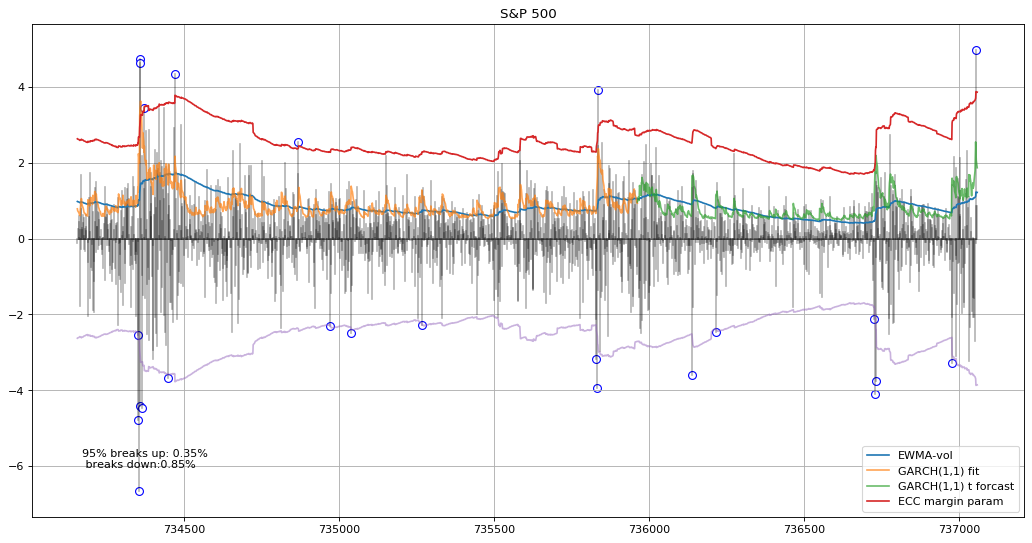

In [48]:
plt.figure(figsize = (16,8), dpi = 80)
nday = len(ES)

X = np.array(ES[['Date','rt']])

ewma_margin = (np.array(residuals)*np.sqrt(ewma))[-2000:]

for i in range(nday): # format for daily return: [x1,x2],[y1,y2]
    plt.plot([X[i,0], X[i,0]], [0,X[i,1]], 'black', alpha = 0.3)

plt.plot(ES['Date'], ewma[-2000:], label = 'EWMA-vol')
plt.plot(ES['Date'], res1.conditional_volatility, label = 'GARCH(1,1) fit', alpha = 0.7)
# plt.plot(ES['Date'], res2.conditional_volatility, label = 'GARCH(1,1) t fit')
# plt.plot(ES['Date'], np.sqrt(res1.forecast().variance), label = 'GARCH(1,1) forcast')
plt.plot(ES['Date'], np.sqrt(res2.forecast().variance), label = 'GARCH(1,1) t forcast', alpha = 0.7)
plt.plot(ES['Date'], ewma_margin, label = 'ECC margin param')
plt.plot(ES['Date'], -ewma_margin, alpha = 0.5)



breaksup = breaksdown = 0
for i in range(2000):
    if (abs(X[i,1]) > abs(ewma_margin[i]) ):
        plt.scatter(X[i,0], X[i,1], color = 'white', marker = "o", edgecolors = 'b', s = 50)
        if (X[i,1] > ewma_margin[i]):
            breaksup +=1
        else:
            breaksdown += 1
breaksup /= 2000
breaksdown /=2000
plt.annotate('95% breaks up: {:.2%} \n breaks down:{:.2%}'.format(breaksup, breaksdown), xy = (0.05, 0.1), xycoords = 'axes fraction')

plt.grid(); plt.legend(); plt.title('S&P 500')
plt.show()

We constate that EWMA-vol is much more gliss than what predicted by GARCH(1,1). While they generally have similar values. Actually, the GARCH can be approximated by EWMA. In our case we have used a lookback period for 255 days and a lambda=0.99. If we change this period to around 10 days with lambda around 0.9, we get similar estimation as GARCH(1,1). 

We also remark that EWMA is in this sense accurate and corresponds to our practical use: exchanges won't change the maintance margin charge oftenly, because this leads to frequenty clearing and margin call. 

In [49]:
# ## Last work day
# today = dt.date.today()
# today
# today = dt.date(2020,8,17)
# offset = max(1,(today.weekday()+6)%7 - 3)
# last_workday